In [ ]:
import ray
ray.shutdown()
ray.init(num_cpus=3)

debug = False
CMDP_type = "streaming"  # choose "random", "streaming", or "linear"
# NUM_SEEDS = 30
NUM_SEEDS = 3

record_resol = 100  # regret is recorded every 100 steps

2025-07-30 18:27:26,455	INFO worker.py:1888 -- Started a local Ray instance.


100%|██████████| 5000/5000 [21:36<00:00,  3.86it/s]


In [59]:
# Hyperparameters

if CMDP_type == "random":
    Cr_coef = 0.1
    Cu_coef = 0.05
    Cd_coef = 0.1
    Clam_coef = 100
    ENT_COEF = 0.1

elif CMDP_type == "streaming":
    Cr_coef = 10
    Cu_coef = 5
    Cd_coef = 10
    Clam_coef = 100
    ENT_COEF = 0.1

elif CMDP_type == "linear":
    Cr_coef = 2
    Cu_coef = 2
    Cd_coef = 2
    Clam_coef = 100
    ENT_COEF = 0.01

In [60]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple, Optional
from jax.random import PRNGKey
import chex

class CMDP(NamedTuple):
    S_set: jnp.array  # state space
    A_set: jnp.array  # action space
    H: int  # horizon
    phi_dim: int  # feature map dimension
    phi: jnp.array  # feature map
    rew: jnp.array  # reward function
    utility: jnp.array  # reward for constraint
    const: float  # constraint threshold
    P: jnp.array  # transition probability kernel
    init_dist: jnp.array  # initial distribution
    xi: float  # safety parameter
    safe_policy: Optional[jnp.array] = None
    optimal_ret: Optional[jnp.array] = None  # optimal return

    @property
    def S(self) -> int:  # state space size
        return len(self.S_set)

    @property
    def A(self) -> int:  # action space size
        return len(self.A_set)



In [61]:
if CMDP_type == "random":
    S, A = 10, 3
    d = S * A
    H = 5
    K = 500000  # number of episodes
    const_scale = 0.5

    def create_cmdp(key: PRNGKey) -> CMDP:
        """Randomly generate synthetic CMDP instance."""
        const = 0  # dummy
        xi = 0  # dummy

        S_set = jnp.arange(S)
        A_set = jnp.arange(A)

        # feature map is one-hot vector
        d = S * A
        phi = jnp.eye(d)

        # create reward function
        rew = jnp.ones((H, S, A))
        key, _ = jax.random.split(key)
        zero_mask = jax.random.bernoulli(key, p=0.2, shape=rew.shape)
        rew = rew * zero_mask
        assert rew.shape == (H, S, A)
        assert rew.max() > 0

        # create reward function for constraints
        utility = jnp.ones((H, S, A))
        key, _ = jax.random.split(key)
        zero_mask = jax.random.bernoulli(key, p=0.2, shape=utility.shape)
        utility = utility * zero_mask
        assert utility.shape == (H, S, A)
        assert utility.max() > 0

        # create transition probability kernel
        key, _ = jax.random.split(key)
        P = jax.random.dirichlet(key=key, alpha=jnp.array([0.1] * S), shape=(H, S*A))
        P = P.reshape(H, S, A, S)
        np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)

        # create initial distribution
        key, _ = jax.random.split(key)
        init_dist = jnp.zeros(S)
        x0 = jax.random.randint(key, (), 0, S)
        init_dist = init_dist.at[x0].set(1.0)
        np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)

        cmdp = CMDP(S_set, A_set, H, d, phi, rew, utility, const, P, init_dist, xi=xi)
        return cmdp


In [62]:
if CMDP_type == "streaming":
    buff = 20  # buffer size
    S, A = buff+1, 2  # state and action space sizes
    d = S * A
    H = 10 
    K = 500000  # number of episodes
    const_scale = 0.6

    def create_cmdp(key: PRNGKey) -> CMDP:
        """Randomly generate media streaming CMDP instance."""
        const = 0  # dummy
        xi = 0  # dummy

        S_set = jnp.arange(S)
        A_set = jnp.arange(A)

        # feature map is one-hot vector
        d = S * A
        phi = jnp.eye(d)

        # create reward function
        rew = jnp.zeros((H, S, A))
        rew = rew.at[:, int(buff * 0.3):, :].set(1)  # +1 reward when the buffer is sufficiently full
        assert rew.shape == (H, S, A)

        # create reward function for constraints
        utility = jnp.zeros((H, S, A))
        utility = utility.at[:, :, 1].set(1)  # +1 reward when taking a slow transmission
        assert utility.shape == (H, S, A)

        # create transition probability kernel
        key, _ = jax.random.split(key)

        mu1 = jax.random.uniform(key, minval=0.5, maxval=0.9)  # fast transmission rate
        mu2 = 1 - mu1  # late transmission rate
        key, _ = jax.random.split(key)
        rho = jax.random.uniform(key, minval=0.1, maxval=0.4)  # probability of packet leaving

        # transition matrix
        Ph = jnp.zeros((S, A, S))

        # when s==0
        Ph = Ph.at[0, 0, 0].set(rho * mu1 + (1-rho) * (1-mu1) + rho * (1 - mu1))
        Ph = Ph.at[0, 0, 1].set((1 - rho) * mu1)
        Ph = Ph.at[0, 1, 0].set(rho * mu2 + (1-rho) * (1-mu2) + rho * (1 - mu2))
        Ph = Ph.at[0, 1, 1].set((1 - rho) * mu2)

        # when 0 < s < N
        for s in range(1, S):
            Ph = Ph.at[s, 0, s-1].set(rho * (1 - mu1))
            Ph = Ph.at[s, 0, s].set(rho * mu1 + (1-rho) * (1-mu1))
            Ph = Ph.at[s, 0, s+1].set((1 - rho) * mu1)
            Ph = Ph.at[s, 1, s-1].set(rho * (1 - mu2))
            Ph = Ph.at[s, 1, s].set(rho * mu2 + (1-rho) * (1-mu2))
            Ph = Ph.at[s, 1, s+1].set((1 - rho) * mu2)

        # when s==B
        Ph = Ph.at[buff, 0, buff].set(rho * mu1 + (1-rho) * (1-mu1) + (1 - rho) * mu1)
        Ph = Ph.at[buff, 0, buff-1].set(rho * (1 - mu1))
        Ph = Ph.at[buff, 1, buff].set(rho * mu2 + (1-rho) * (1-mu2) + (1 - rho) * mu2)
        Ph = Ph.at[buff, 1, buff-1].set(rho * (1 - mu2))

        P = jnp.tile(Ph, (H, 1, 1, 1))

        # create initial distribution
        key, _ = jax.random.split(key)
        init_dist = jnp.zeros(S)
        init_dist = init_dist.at[0].set(1.0)
        np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)

        cmdp = CMDP(S_set, A_set, H, d, phi, rew, utility, const, P, init_dist, xi=xi)
        return cmdp



In [63]:
if CMDP_type == "linear":
    S, A = 5, 3
    d = 2
    H = 8 
    K = 1000000  # number of episodes
    const_scale = 0.9

    def create_cmdp(key: PRNGKey) -> CMDP:
        """Randomly generate synthetic CMDP instance."""
        const = 0  # dummy
        xi = 0  # dummy

        S_set = jnp.arange(S)
        A_set = jnp.arange(A)

        # create a linear CMDP based on https://arxiv.org/pdf/2106.06239#page=10.27
        phi = jax.random.dirichlet(key=key, alpha=jnp.array([0.3] * d), shape=(S*A))
        phi = phi.reshape(S*A, d)
        key, _ = jax.random.split(key)

        mu = jax.random.dirichlet(key=key, alpha=jnp.array([0.3] * S), shape=(H*d))
        mu = mu.reshape(H, d, S)
        key, _ = jax.random.split(key)

        P = jnp.einsum('hds,kd->hks', mu, phi).reshape(H, S, A, S)
        np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-5)

        # create reward function
        theta_r = jax.random.uniform(key=key, shape=(H, d))
        key, _ = jax.random.split(key)
        rew = jnp.einsum('hd,kd->hk', theta_r, phi).reshape(H, S, A)
 
        # create reward function for constraints
        theta_u = jax.random.uniform(key, shape=(H, d))
        key, _ = jax.random.split(key)
        utility = jnp.einsum('hd,kd->hk', theta_u, phi).reshape(H, S, A)

        # create initial distribution
        key, _ = jax.random.split(key)
        init_dist = jnp.zeros(S)
        x0 = jax.random.randint(key, (), 0, S)
        init_dist = init_dist.at[x0].set(1.0)
        np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)

        cmdp = CMDP(S_set, A_set, H, d, phi, rew, utility, const, P, init_dist, xi=xi)
        return cmdp

In [64]:
from scipy.optimize import linprog
from itertools import product
from functools import partial


@jax.jit
def compute_greedy_Q(cmdp: CMDP):
    """
    Compute a greedy Q function with respect to the utility function
    Useful for setting the constraint threshold
    """
    def backup(i, greedy_Q):
        h = H - i - 1
        V = greedy_Q[h+1].max(axis=1)
        next_v = cmdp.P[h] @ V
        chex.assert_shape(next_v, (S, A))
        greedy_Q = greedy_Q.at[h].set(cmdp.utility[h] + next_v)
        return greedy_Q

    greedy_Q = jnp.zeros((H+1, S, A))
    greedy_Q = jax.lax.fori_loop(0, cmdp.H, backup, greedy_Q)
    return greedy_Q[:-1]


@jax.jit
def EvalRegQ(policy: jnp.ndarray, rew: jnp.ndarray, P: jnp.ndarray, ent_coef: float, thresh_coef: float = 1.0) -> jnp.ndarray:
    """ Compute value function
    Args:
        policy (np.ndarray): (HxSxA) array
        rew (np.ndarray): (HxSxA) array
        P (np.ndarray): (HxSxSxA) array
        ent_coef (float): regularization parameter
        thresh_coef (float): threshold parameter

    Returns:
        Q (jnp.ndarray): (HxSxA)
    """

    def backup(i, args):
        policy_Q= args
        h = H - i - 1
        Q = policy_Q[h+1] + ent_coef * jax.scipy.special.entr(policy[h+1])
        V = (policy[h+1] * Q).sum(axis=1)
        next_v = P[h] @ V
        chex.assert_shape(next_v, (S, A))
        policy_Q = policy_Q.at[h].set(rew[h] + next_v)
        min_thresh = thresh_coef * (1 + ent_coef * jnp.log(A)) * (H - h)
        policy_Q = jnp.maximum(jnp.minimum(policy_Q, min_thresh), 0)
        return policy_Q

    policy_Q= jnp.zeros((H+1, S, A))
    args = policy_Q
    policy_Q= jax.lax.fori_loop(0, H, backup, args)
    return policy_Q[:-1]



In [65]:
if debug:
    # test
    key = PRNGKey(0)
    cmdp = create_cmdp(key)
    # test_feature = np.zeros(S*A)
    # test_feature[A * 1 + 2] = 1
    # np.testing.assert_allclose(cmdp.phi[A * 1 + 2], test_feature, atol=1e-4)

    # test
    uni_policy = jnp.ones((H, S, A)) / A
    Q_rew_reg = EvalRegQ(uni_policy, cmdp.rew, cmdp.P, 0.1)
    Q_rew= EvalRegQ(uni_policy, cmdp.rew, cmdp.P, 0)
    assert jnp.all(Q_rew_reg >= Q_rew)

In [66]:
@jax.jit
def compute_greedy_policy(Q: jnp.ndarray):
    """ Compute a greedy policy with respect to the Q function"""
    greedy_policy = jnp.zeros_like(Q)
    H, S, A = Q.shape
    
    def body_fn(i, greedy_policy):
        greedy_policy = greedy_policy.at[i, jnp.arange(S), Q[i].argmax(axis=-1)].set(1)
        return greedy_policy

    greedy_policy = jax.lax.fori_loop(0, H, body_fn, greedy_policy)
    chex.assert_shape(greedy_policy, (H, S, A))
    return greedy_policy


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    Args:
        policy (jnp.ndarray): (HxSxA) matrix

    Returns:
        policy_matrix (jnp.ndarray): (HxSxSA) matrix
    """
    H, S, A = policy.shape
    PI = policy.reshape(H, 1, S, A)
    PI = jnp.tile(PI, (1, S, 1, 1))
    eyes = jnp.tile(jnp.eye(S).reshape(1, S, S, 1), (H, 1, 1, 1))
    PI = (eyes * PI).reshape(H, S, S*A)
    return PI


@jax.jit
def compute_occupancy_measure(cmdp: CMDP, policy: jnp.ndarray):
    """
    Args:
        cmdp (CMDP)
        policy (jnp.ndarray): (HxSxA) matrix

    Returns:
        occ (jnp.ndarray): (HxSxA) matrix
    """
    Pi = compute_policy_matrix(policy)
    P = cmdp.P.reshape(H, S*A, S)

    def body_fn(h, occ):
        next_occ = occ[h] @ P[h] @ Pi[h+1]
        occ = occ.at[h+1].set(next_occ)
        return occ
    
    occ = jnp.zeros((H+1, S*A))
    occ = occ.at[0].set((cmdp.init_dist @ Pi[0]))
    occ = jax.lax.fori_loop(0, cmdp.H, body_fn, occ)
    occ = occ[:-1].reshape(H, S, A)
    return occ


In [67]:
@jax.jit
def compute_optimal_rew_util(cmdp: CMDP):
    # Compute the optimal policy using Lagrange method

    lr = 0.05
    iter_length = 500  # number of iterations

    def body_fn(i, args):
        avg_occ, lam = args

        ru = cmdp.rew + lam * cmdp.utility
        pol = compute_greedy_policy(compute_greedy_Q(cmdp._replace(utility=ru)))
        occ = compute_occupancy_measure(cmdp, pol)
        avg_occ = avg_occ + occ / iter_length
        total_utility = (occ * cmdp.utility).sum()
        lam = jnp.maximum(lam - lr * (total_utility - cmdp.const), 0)
        return avg_occ, lam

    lam = 0.0
    avg_occ = jnp.zeros((H, S, A))

    avg_occ, _ = jax.lax.fori_loop(0, iter_length, body_fn, (avg_occ, lam))
    optimal_rew = (avg_occ * cmdp.rew).sum()
    optimal_util = (avg_occ * cmdp.utility).sum()
    return optimal_rew, optimal_util


def compute_optimal_rew_util_LP(cmdp: CMDP):
    # for debug
    B = np.zeros((H, S, A, H, S, A))

    for s, a in product(range(S), range(A)):
        B[0, s, a, 0, s] = 1

    for h, s, a in product(range(1, H), range(S), range(A)):
        B[h, s, a, h, s] = 1
        B[h, s, a, h-1] = -cmdp.P[h-1, :, :, s]

    B = B.reshape((H*S*A, H*S*A))
    mu = np.repeat(cmdp.init_dist[:, None], A, axis=1).reshape(-1)
    b = np.hstack((mu, np.zeros((H-1)*S*A)))

    U = cmdp.utility.reshape(1, -1)
    u = np.array((cmdp.const,))

    r = - cmdp.rew.reshape(-1)
    lin_res = linprog(r, A_eq=B, b_eq=b, bounds=(0, None), A_ub=-U, b_ub=-u)

    d_arr = lin_res.x.reshape(H, S, A)
    np.testing.assert_allclose(d_arr.sum(axis=(1, 2)), 1.0, atol=1e-4)

    optimal_rew = (d_arr * cmdp.rew).sum()
    optimal_util = (d_arr * cmdp.utility).sum()
    return optimal_rew, optimal_util


# if debug:
#     # test
#     optimal_rew, optimal_util = compute_optimal_rew_util(cmdp)
#     optimal_rew_LP, optimal_util_LP = compute_optimal_rew_util_LP(cmdp)

#     np.testing.assert_allclose(optimal_rew, optimal_rew_LP, atol=1e-1)
#     np.testing.assert_allclose(optimal_util, optimal_util_LP, atol=1e-1)
#     assert optimal_util >= cmdp.const - 0.1, f"total_utility: {optimal_util}, const: {cmdp.const}"

In [68]:
def set_cmdp_info(cmdp: CMDP) -> CMDP:
    """Set CMDP information, such as optimal policy, constraint threshold, etc."""
    greedy_Q = compute_greedy_Q(cmdp)
    safe_policy = compute_greedy_policy(greedy_Q)
    maximum_utility = (greedy_Q).max(axis=-1)[0] @ cmdp.init_dist
    const = cmdp.H / 2  # maximum_utility * const_scale
    xi = maximum_utility - const

    # Set safety related parameters
    cmdp = cmdp._replace(const=const, xi=xi, safe_policy=safe_policy)

    # set the optimal policy
    total_rew, _ = compute_optimal_rew_util(cmdp)
 
    cmdp = cmdp._replace(optimal_ret=total_rew)
    return cmdp

if debug:
    # test
    cmdp = set_cmdp_info(cmdp)


In [69]:
@jax.jit
def deploy_policy_episode(mdp: CMDP, key: PRNGKey, policy: jnp.array, init_s: int):
    """ collect data through interaction to the mdp 
    Args:
        mdp (MDP)
        H (int)
        key (PRNGKey)
        policy (jnp.ndarray)
        init_s (int): initial state

    Returns:
        new_key (PRNGKey)
        traj (jnp.ndarray): (H x 3) collected trajectory H x (s, a, s')
    """
    H, S, A, S = mdp.P.shape
    chex.assert_shape(policy, (H, S, A))

    def body_fn(h, args):
        key, s, traj = args
        key, new_key = jax.random.split(key)
        act = jax.random.choice(new_key, A, p=policy[h, s])

        # sample next state
        key, new_key = jax.random.split(key)
        next_s = jax.random.choice(new_key, mdp.S_set, p=mdp.P[h, s, act])

        sa = s * A + act
        traj = traj.at[h].add(jnp.array([sa, next_s]))
        return key, next_s, traj

    traj= jnp.zeros((H, 2), dtype=jnp.int32)  # H x (sa, s')
    args = key, init_s, traj
    key, _, traj = jax.lax.fori_loop(0, H, body_fn, args)
    return key, traj

In [70]:
@jax.jit
def sample_and_compute_regret(key, cmdp: CMDP, policy):
    """Deploy a policy and compute the regret"""
    # sample data and update visitation counter
    key, init_key = jax.random.split(key)
    init_s = jax.random.choice(init_key, S, p=cmdp.init_dist)
    key, traj = deploy_policy_episode(cmdp, key, policy, init_s)

    # compute temporal regret
    Q_rew= EvalRegQ(policy, cmdp.rew, cmdp.P, 0)
    Q_utility = EvalRegQ(policy, cmdp.utility, cmdp.P, 0)
    init_dist = cmdp.init_dist
    total_rew = ((Q_rew * policy)[0].sum(axis=-1) * init_dist).sum()
    total_utility = ((Q_utility * policy)[0].sum(axis=-1) * init_dist).sum()
    
    err_rew = cmdp.optimal_ret - total_rew
    err_vio = cmdp.const - total_utility
    return key, traj, err_rew, err_vio

In [71]:
def traj_to_phi_phi(traj: jnp.ndarray, cmdp: CMDP) -> jnp.ndarray:
    """ convert trajectory to phi phi^T
    Args:
        traj (jnp.ndarray): (H x 2) array

    Returns:
        phi_phi (jnp.ndarray): (H x d x d)
    """
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    phi_phi = jax.vmap(jnp.dot)(Phi.reshape(H, d, 1), Phi.reshape(H, 1, d))
    return phi_phi


def traj_to_phi_V(traj: jnp.ndarray, V: jnp.ndarray, cmdp: CMDP) -> jnp.ndarray:
    """ convert trajectory to phi phi^T
    Args:
        traj (jnp.ndarray): (H x 2) array
        V (jnp.ndarray): (H x S) array

    Returns:
        phi_V (jnp.ndarray): (H x d)
    """
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    V = V[jnp.arange(H), traj[:, 1]].reshape(H, 1)  # (H x 1)
    phi_V = jax.vmap(jnp.multiply)(Phi, V)
    return phi_V

In [72]:
if debug:
    # test
    key, traj = deploy_policy_episode(cmdp, key, uni_policy, 0)
    V = jax.random.uniform(key, (H, S))
    phi_phi = traj_to_phi_phi(traj, cmdp)
    phi_V = traj_to_phi_V(traj, V, cmdp)
    chex.assert_shape(phi_phi, (H, d, d))
    chex.assert_shape(phi_V, (H, d))

    # ===== compute bonus function =====
    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda = Lambda + phi_phi
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)
    chex.assert_shape(Lambda_inv, (H, d, d))

    phi_Lambda_inv = jnp.einsum('kd,hde->hke', cmdp.phi, Lambda_inv)
    chex.assert_shape(phi_Lambda_inv, (H, S*A, d))
    bonus = jnp.sqrt(jnp.einsum('hkd,kd->hk', phi_Lambda_inv, cmdp.phi)).reshape(H, S, A)

    # ===== compute estimated P =====
    mu = jnp.zeros((H, S, d))

    @jax.vmap
    def update_mu(mu, traj, phi_Lambda_inv):
        sa, ns = traj
        mu = mu.at[ns].add(phi_Lambda_inv[sa])
        return mu

    mu = update_mu(mu, traj, phi_Lambda_inv)
    chex.assert_shape(mu, (H, S, d))

    est_P = jax.vmap(jnp.dot, in_axes=(None, 0))(cmdp.phi, jnp.transpose(mu, (0, 2, 1))).reshape(H, S, A, S)
    _est_P = jnp.einsum('hsd,kd->hks', mu, cmdp.phi).reshape(H, S, A, S)

    np.testing.assert_allclose(est_P, _est_P, atol=1e-4)

# Proposed Algorithm (Algorithm 2)

In [73]:
@jax.jit
def compute_Q_h(Q_nh: jnp.ndarray, pol_nh: jnp.ndarray, bonus_h: jnp.ndarray, rew_h: jnp.ndarray, P_h: jnp.ndarray, ent_coef: float, thresh: float) -> jnp.ndarray:
    Q_nh_reg = Q_nh + ent_coef * jax.scipy.special.entr(pol_nh)
    V_nh = (pol_nh * Q_nh_reg).sum(axis=1)

    next_v = bonus_h + P_h @ V_nh
    next_v = jnp.maximum(jnp.minimum(next_v, thresh), 0)
    chex.assert_shape(next_v, (S, A))
    return rew_h + next_v 


@jax.jit
def compute_softmax_pol_h(rQ_h, dQ_h, uQ_h, ent_coef, lam):
    Q_h = dQ_h + rQ_h + lam * uQ_h
    return jax.nn.softmax(Q_h / ent_coef, axis=-1)


# test 
if debug:
    rQ = jnp.zeros((H+1, S, A))
    dQ = jnp.zeros((H+1, S, A))
    uQ = jnp.zeros((H+1, S, A))
    policy= jnp.ones((H+1, S, A)) / A

    i = 0
    h = H - i - 1

    Cr = d * H * 0.1
    Cu = Cr 
    Cd = d ** 2 * H ** 3 / cmdp.xi
    Bd = d * H ** 2 / cmdp.xi
    ent_coef = 1e-4

    rthresh = (1 + ent_coef * jnp.log(A)) * (H - h)
    rQ_h = compute_Q_h(rQ[h+1], policy[h+1], Cr * bonus[h], cmdp.rew[h], est_P[h], ent_coef, rthresh)

    dthresh = Bd * (H - h)
    dQ_h = compute_Q_h(dQ[h+1], policy[h+1], Cd * bonus[h], Bd * bonus[h], est_P[h], 0, dthresh)

    uthresh = (H - h)
    uQ_h = compute_Q_h(uQ[h+1], policy[h+1], -Cu * bonus[h], cmdp.utility[h], est_P[h], 0, uthresh)

    compute_softmax_pol_h(rQ_h, dQ_h, uQ_h, ent_coef, 0.1)

In [74]:
@jax.jit
def compute_softmax_pol(bonus: jnp.ndarray, cmdp: CMDP, ent_coef: float, lam: float, Cr: float, Cd: float, Cu: float, Bd: float) -> jnp.ndarray:
    def backup(i, args):
        rQ, dQ, uQ, pol = args
        h = H - i - 1

        rthresh = (1 + ent_coef * jnp.log(A)) * (H - h)
        rQ_h = compute_Q_h(rQ[h+1], pol[h+1], Cr * bonus[h], cmdp.rew[h], cmdp.P[h], ent_coef, rthresh)

        dthresh = Bd * (H - h)
        dQ_h = compute_Q_h(dQ[h+1], pol[h+1], Cd * bonus[h], Bd * bonus[h], cmdp.P[h], 0, dthresh)

        uthresh = (H - h)
        uQ_h = compute_Q_h(uQ[h+1], pol[h+1], -Cu * bonus[h], cmdp.utility[h], cmdp.P[h], 0, uthresh)

        pol_h = compute_softmax_pol_h(rQ_h, dQ_h, uQ_h, ent_coef, lam)

        rQ = rQ.at[h].set(rQ_h)
        dQ = dQ.at[h].set(dQ_h)
        uQ = uQ.at[h].set(uQ_h)
        pol = pol.at[h].set(pol_h)
        return rQ, dQ, uQ, pol

    rQ = jnp.zeros((H+1, S, A))
    dQ = jnp.zeros((H+1, S, A))
    uQ = jnp.zeros((H+1, S, A))
    pol = jnp.ones((H+1, S, A)) / A

    args = rQ, dQ, uQ, pol
    rQ, dQ, uQ, pol = jax.lax.fori_loop(0, H, backup, args)

    uV = jnp.sum(uQ * pol, axis=-1)
    total_util = cmdp.init_dist @ uV[0]
    return total_util, pol[:-1]

if debug:
    Clam = 1000
    est_cmdp = cmdp._replace(P=est_P)
    uV_up, pol_up = compute_softmax_pol(bonus, est_cmdp, ent_coef, Clam, Cr, Cd, Cu, Bd)
    uV_low, pol_low = compute_softmax_pol(bonus, est_cmdp, ent_coef, 0, Cr, Cd, Cu, Bd)
    print(jax.lax.cond(uV_up >= cmdp.const, lambda: 3, lambda: 2))

In [75]:
@jax.vmap
def Sherman_Morrison_update_H(Lambda_inv: jnp.ndarray, phi: jnp.ndarray) -> jnp.ndarray:
    """Update the inverse of the Lambda_matrix using the Sherman-Morrison formula.
    Due to the vmap, the input Lambda_inv is expected to be of shape (H x d x d) and phi of shape (H x d).
    
    Args:
        Lambda_inv (jnp.ndarray): (d x d) matrix
        phi (jnp.ndarray): d vector
    
    Return:
        Lambda_inv (jnp.ndarray): (d x d)
    """
    # Sherman-Morrison formula: (A + u v^T)^(-1) = A_inv - (A_inv u v^T A_inv) / (1 + v^T A_inv u)
    phi = phi.reshape(-1, 1)  # (d, 1)
    numerator = Lambda_inv @ phi @ phi.T @ Lambda_inv  # (d, d)
    denominator = 1.0 + (phi.T @ Lambda_inv @ phi)[0, 0]  # scalar
    return Lambda_inv - numerator / denominator

In [ ]:
from functools import partial
import jax
import chex
from tqdm import tqdm


@jax.jit
def update(_, args):
    args1, args2 = args
    regret, vio_regret, safe_deploy_sum = args1
    key, pol, cmdp, Lambda_inv, ephi_sum = args2

    # hyperparameters
    Cr = Cr_coef * d * H
    Cu = Cu_coef * d * H
    Cd = Cd_coef * d ** 2 * H ** 3 / cmdp.xi
    # Bd = 0.1 * d * H ** 2 / cmdp.xi
    Bd = 1
    Clam = Clam_coef * d * H ** 4 / (cmdp.xi ** 2)
    ent_coef = ENT_COEF

    key, traj, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    err_vio = jnp.maximum(err_vio, 0)

    # ===== compute bonus function =====
    Phi = cmdp.phi[traj[:, 0]]  # (H x d)
    Lambda_inv = Sherman_Morrison_update_H(Lambda_inv, Phi)

    # bonus = jnp.sqrt(jnp.maximum(bonus, 0))  # the maximum is to avoid numerical issues

    # ===== compute estimated P =====
    @jax.vmap
    def update_ephi_sum(ephi_sum, traj):
        sa, ns = traj
        ephi_sum = ephi_sum.at[ns].add(cmdp.phi[sa])
        return ephi_sum

    ephi_sum = update_ephi_sum(ephi_sum, traj)
    mu = ephi_sum @ Lambda_inv
    chex.assert_shape(mu, (H, S, d))
    est_P = jnp.einsum('hsd,kd->hks', mu, cmdp.phi).reshape(H, S, A, S)

    # ===== search sufficiently small lambda =====
    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cd, Cu, Bd)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    lam_range = jax.lax.fori_loop(0, 20, body_fn, jnp.array((0.0, Clam), dtype=jnp.float32))
    _, pol = compute_softmax_pol(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cd, Cu, Bd)
    # pol = jax.lax.cond(lam_range[1] == Clam, lambda: cmdp.safe_policy, lambda: pol)

    is_safe_deployed = lam_range[1] == Clam

    regret = regret + err_rew
    vio_regret = vio_regret + err_vio
    safe_deploy_sum = safe_deploy_sum + is_safe_deployed
    return (regret, vio_regret, safe_deploy_sum), (key, pol, cmdp, Lambda_inv, ephi_sum)


@jax.jit
def multiple_updates(args):
    return jax.lax.fori_loop(0, record_resol, update, args)


def RunAlgo(cmdp: CMDP, iteration: int, seed):
    key = PRNGKey(seed)

    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    episodes = []
    regrets = []
    vio_regrets = []
    safe_deploy_sums = []

    pol = cmdp.safe_policy
    args = (0, 0, 0), (key, pol, cmdp, Lambda_inv, ephi_sum)
    epi_sum = 0

    # Record the initial results
    for _ in tqdm(range(record_resol)):
        args = update(0, args)
        (regret, vio_regret, safe_deploy_sum), _ = args
        epi_sum += 1
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)
        safe_deploy_sums.append(safe_deploy_sum)

    for _ in tqdm(range(int(iteration / record_resol))):
        args = multiple_updates(args)
        (regret, vio_regret, safe_deploy_sum), _ = args

        epi_sum += record_resol
        episodes.append(epi_sum)
        regrets.append(regret)
        vio_regrets.append(vio_regret)
        safe_deploy_sums.append(safe_deploy_sum)
    return np.array(episodes), np.array(regrets), np.array(vio_regrets), np.array(safe_deploy_sums)

In [77]:
if debug:
    key = PRNGKey(1)

    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)
    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    episodes = []
    regrets = []
    vio_regrets = []
    safe_deploy_sums = []

    pol = cmdp.safe_policy
    args = (0, 0, 0), (key, pol, cmdp, Lambda_inv, ephi_sum)
    epi_sum = 0

    for _ in tqdm(range(int(10000))):
        args = multiple_updates(args)
        (regret, vio_regret, safe_deploy_sum), _ = args

        regrets.append(regret)
        vio_regrets.append(vio_regret)
        safe_deploy_sums.append(safe_deploy_sum)

    vio_regrets[-1]

In [78]:
if debug:
    _, (key, pol, cmdp, Lambda_inv, ephi_sum) = args

    mu = ephi_sum @ Lambda_inv
    est_P = jnp.einsum('hsd,kd->hks', mu, cmdp.phi).reshape(H, S, A, S)
    print("est error", jnp.abs(est_P - cmdp.P)[1:].max())

    phi_Lambda_inv = jnp.einsum('kd,hde->hke', cmdp.phi, Lambda_inv)
    chex.assert_shape(phi_Lambda_inv, (H, S*A, d))
    bonus = jnp.einsum('hkd,kd->hk', phi_Lambda_inv, cmdp.phi).reshape(H, S, A)
    bonus = jnp.sqrt(jnp.maximum(bonus, 0))  # the maximum is to avoid numerical issues
    print("bonus", bonus[1:].max())


    # ===== search sufficiently small lambda =====
    Cr = 1.0
    Cu = 100
    Cd = 6
    # Bd = 0.1 * d * H ** 2 / cmdp.xi
    Bd = 1
    Clam = Clam_coef * d * H ** 4 / (cmdp.xi ** 2)
    ent_coef = 0.01


    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cd, Cu, Bd)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    print("parameters", Cr, Cu, Cd, Bd)
    lam_range = jax.lax.fori_loop(0, 30, body_fn, jnp.array((0.0, Clam), dtype=jnp.float32))
    util_est, pol = compute_softmax_pol(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cd, Cu, Bd)
    pol = jax.lax.cond(lam_range[1] == Clam, lambda: cmdp.safe_policy, lambda: pol)
    print("est safe", util_est - cmdp.const)

    _, _, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    print("exact vio", err_vio)
    print("exact reg", err_rew)

In [79]:
if debug:
    est_cmdp = cmdp

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(bonus, est_cmdp, ent_coef, mid_lam, Cr, Cd, Cu, Bd)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range

    print(Cr, Cu, Cd, Bd)
    lam_range = jax.lax.fori_loop(0, 20, body_fn, jnp.array((0.0, Clam), dtype=jnp.float32))
    util_est, pol = compute_softmax_pol(bonus, est_cmdp, ent_coef, lam_range[1], Cr, Cd, Cu, Bd)
    pol = jax.lax.cond(lam_range[1] == Clam, lambda: cmdp.safe_policy, lambda: pol)
    print(util_est - cmdp.const)

    _, _, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)
    print(err_rew, err_vio)

In [80]:
if debug:
    Lambda = jnp.tile(jnp.eye(d), (H, 1, 1))  # H x d x d
    Lambda_inv = jax.vmap(jnp.linalg.pinv)(Lambda)  # H x d x d
    ephi_sum = jnp.zeros((H, S, d))

    pol = cmdp.safe_policy
    args = (0, 0, 0), (key, pol, cmdp, Lambda_inv, ephi_sum)
    epi_sum = 0

    for _ in tqdm(range(int(1000))):
        args = multiple_updates(args)
        (regret, vio_regret, safe_deploy_sum), (key, pol, cmdp, Lambda_inv, ephi_sum) = args
        phi_Lambda_inv = jnp.einsum('kd,hde->hke', cmdp.phi, Lambda_inv)
        chex.assert_shape(phi_Lambda_inv, (H, S*A, d))
        bonus = jnp.einsum('hkd,kd->hk', phi_Lambda_inv, cmdp.phi).reshape(H, S, A)
        # print(bonus[1:].min(), bonus[1:].max())

        mu = ephi_sum @ Lambda_inv
        est_P = jnp.einsum('hsd,kd->hks', mu, cmdp.phi).reshape(H, S, A, S)
        error_P = jnp.abs(est_P[1:] - cmdp.P[1:]).mean()
        print(error_P)

        # print(Lambda_inv.min(), Lambda_inv.max())
 

In [81]:
if debug:
    est_cmdp = cmdp._replace(P=est_P)

    def body_fn(_, lam_range):
        lam_low, lam_high = lam_range
        mid_lam = (lam_low + lam_high) / 2
        util, _ = compute_softmax_pol(jnp.zeros_like(bonus), est_cmdp, ent_coef, mid_lam, 0, 0, 0, 0)
        is_util_safe = util >= cmdp.const
        next_lam_range = jax.lax.cond(
            is_util_safe,
            lambda: jnp.array((lam_low, mid_lam)),
            lambda: jnp.array((mid_lam, lam_high))
        )
        return next_lam_range


    lam_range = jnp.array((0.0, Clam))
    for i in range(30):
        lam_range = body_fn(i, lam_range)
    util, pol = compute_softmax_pol(jnp.zeros_like(bonus), est_cmdp, ent_coef, lam_range[1], 0, 0, 0, 0)
    print(util- cmdp.const)

# Ghosh[2024]'s Algorithm

In [ ]:

@jax.jit
def compute_softmax_pol_h_Ghosh(rQ_h, uQ_h, ent_coef, lam):
    Q_h = rQ_h + lam * uQ_h
    return jax.nn.softmax(Q_h / ent_coef, axis=-1)


@jax.jit
def compute_softmax_pol_Ghosh(bonus: jnp.ndarray, cmdp: CMDP, ent_coef: float, lam: float, Cr: float, Cu: float) -> jnp.ndarray:
    def backup(i, args):
        rQ, uQ, pol = args
        h = H - i - 1

        thresh = H - h
        rQ_h = compute_Q_h(rQ[h+1], pol[h+1], Cr * bonus[h], cmdp.rew[h], cmdp.P[h], 0, thresh)
        uQ_h = compute_Q_h(uQ[h+1], pol[h+1], Cu * bonus[h], cmdp.utility[h], cmdp.P[h], 0, thresh)
        pol_h = compute_softmax_pol_h_Ghosh(rQ_h, uQ_h, ent_coef, lam)

        rQ = rQ.at[h].set(rQ_h)
        uQ = uQ.at[h].set(uQ_h)
        pol = pol.at[h].set(pol_h)
        return rQ, uQ, pol

    rQ = jnp.zeros((H+1, S, A))
    uQ = jnp.zeros((H+1, S, A))
    pol = jnp.ones((H+1, S, A)) / A

    args = rQ, uQ, pol
    rQ, uQ, pol = jax.lax.fori_loop(0, H, backup, args)

    uV = jnp.sum(uQ * pol, axis=-1)
    total_util = cmdp.init_dist @ uV[0]
    return total_util, pol[:-1]



# Uniform policy

In [83]:
def RunUniPolicy(cmdp: CMDP, iteration: int, seed):

    pol = jnp.ones((H, S, A)) / A
    key = PRNGKey(seed)  # dummy. computing temporal regret does not require randomness here.
    key, _, err_rew, err_vio = sample_and_compute_regret(key, cmdp, pol)

    errors_rew = [err_rew] * int(iteration / record_resol)
    regrets = np.cumsum(errors_rew) * record_resol
    errors_vio = [np.maximum(err_vio, 0)] * int(iteration / record_resol)
    vio_regrets = np.cumsum(errors_vio) * record_resol
    episodes = np.arange(int(iteration / record_resol)) * record_resol + 1
    return np.array(episodes), np.array(regrets), np.array(vio_regrets)

In [84]:
if debug:
    _K = 10000
    key = PRNGKey(0)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes, regrets, vio_regrets, safe_deploy_sums, errors_P = RunAlgo(cmdp, K, 0)
    # RunAlgoGhosh(cmdp, _K, 0)
    # RunUniPolicy(cmdp, _K, 0)

# Run Algorithms

In [85]:
import ray


@ray.remote
class Buffer:
    def __init__(self):
        self.episodes = []
        self.regrets = []
        self.vio_regrets = []
        self.safe_deploy_sums = []

        self.episodes_Ghosh = []
        self.regrets_Ghosh = []
        self.vio_regrets_Ghosh = []

        self.episodes_uni = []
        self.regrets_uni = []
        self.vio_regrets_uni = []

    def add_proposal(self, episodes, regrets, vio_regrets, safe_deploy_sums):
        self.episodes.append(episodes)
        self.regrets.append(regrets)
        self.vio_regrets.append(vio_regrets)
        self.safe_deploy_sums.append(safe_deploy_sums)

    def add_Ghosh(self, episodes_Ghosh, regrets_Ghosh, vio_regrets_Ghosh):
        self.episodes_Ghosh.append(episodes_Ghosh)
        self.regrets_Ghosh.append(regrets_Ghosh)
        self.vio_regrets_Ghosh.append(vio_regrets_Ghosh)

    def add_uni(self, episodes_uni, regrets_uni, vio_regrets_uni):
        self.episodes_uni.append(episodes_uni)
        self.regrets_uni.append(regrets_uni)
        self.vio_regrets_uni.append(vio_regrets_uni)

    def get(self):
        episodes = np.array(self.episodes)
        regrets = np.array(self.regrets)
        vio_regrets = np.array(self.vio_regrets)
        deploy_sums = np.array(self.safe_deploy_sums)

        Ghosh_episodes = np.array(self.episodes_Ghosh)
        Ghosh_regrets = np.array(self.regrets_Ghosh)
        Ghosh_vio_regrets = np.array(self.vio_regrets_Ghosh)

        uni_episodes = np.array(self.episodes_uni)
        uni_regrets = np.array(self.regrets_uni)
        uni_vio_regrets = np.array(self.vio_regrets_uni)

        return episodes, regrets, vio_regrets, deploy_sums, Ghosh_episodes, Ghosh_regrets, Ghosh_vio_regrets, uni_episodes, uni_regrets, uni_vio_regrets


@ray.remote
def run_proposal(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes, regrets, vio_regrets, safe_deploy_sums = RunAlgo(cmdp, K, seed)

    buffer.add_proposal.remote(
        np.array(episodes),
        np.array(regrets),
        np.array(vio_regrets),
        np.array(safe_deploy_sums),
    )


@ray.remote
def run_Ghosh(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes_Ghosh, regrets_Ghosh, vio_regrets_Ghosh = RunAlgoGhosh(cmdp, K, seed)

    buffer.add_Ghosh.remote(
        np.array(episodes_Ghosh),
        np.array(regrets_Ghosh),
        np.array(vio_regrets_Ghosh),
    )


@ray.remote
def run_uni(buffer, seed):
    key = PRNGKey(seed)
    cmdp = create_cmdp(key)
    cmdp = set_cmdp_info(cmdp)

    episodes_uni, regrets_uni, vio_regrets_uni = RunUniPolicy(cmdp, K, seed)

    buffer.add_uni.remote(
        np.array(episodes_uni),
        np.array(regrets_uni),
        np.array(vio_regrets_uni)
    )


buffer = Buffer.remote()

jobs = []
for i in range(NUM_SEEDS):
    jobs.append(run_proposal.remote(buffer, i))
    jobs.append(run_Ghosh.remote(buffer, i))
    jobs.append(run_uni.remote(buffer, i))

_ = ray.get(jobs)

In [86]:
import pickle

with open(f"results-{CMDP_type}.pkl", "wb") as f:
    results = ray.get(buffer.get.remote())
    pickle.dump(results, f)

In [87]:
import pickle
with open(f"results-{CMDP_type}.pkl", "rb") as f:
    results = pickle.load(f)
    episodes, regrets, vio_regrets, deploy_sums, Ghosh_episodes, Ghosh_regrets, Ghosh_vio_regrets, uni_episodes, uni_regrets, uni_vio_regrets = results

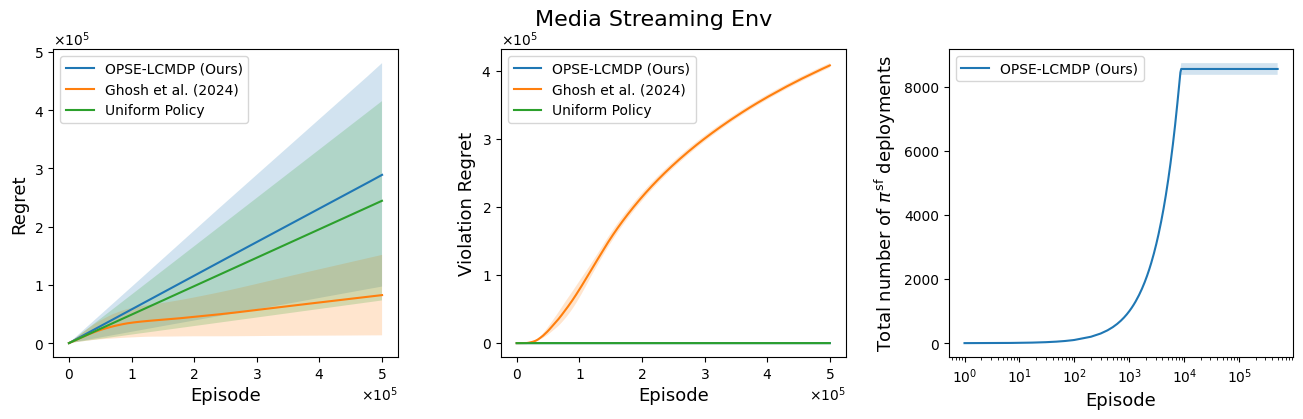

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


class FixedOrderFormatter(ScalarFormatter):
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=True):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        self.orderOfMagnitude = self._order_of_mag


# Compute mean and std
epi_mean = episodes.mean(axis=0)
reg_mean, reg_std = regrets.mean(axis=0), regrets.std(axis=0)
vio_mean, vio_std = vio_regrets.mean(axis=0), vio_regrets.std(axis=0)
deploy_mean, deploy_std = deploy_sums.mean(axis=0), deploy_sums.std(axis=0)

Ghosh_epi_mean = Ghosh_episodes.mean(axis=0)
Ghosh_reg_mean, Ghosh_reg_std = Ghosh_regrets.mean(axis=0), Ghosh_regrets.std(axis=0)
Ghosh_vio_mean, Ghosh_vio_std = Ghosh_vio_regrets.mean(axis=0), Ghosh_vio_regrets.std(axis=0)

uni_epi_mean = uni_episodes.mean(axis=0)
uni_reg_mean, uni_reg_std = uni_regrets.mean(axis=0), uni_regrets.std(axis=0)
uni_vio_mean, uni_vio_std = uni_vio_regrets.mean(axis=0), uni_vio_regrets.std(axis=0)


# Plot with std bars
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.3)

# Plot cumulative reward
ax = fig.add_subplot(1, 3, 1)
ax.plot(epi_mean, reg_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax.fill_between(epi_mean, reg_mean - reg_std, reg_mean + reg_std, alpha=0.2)
ax.plot(Ghosh_epi_mean, Ghosh_reg_mean, label="Ghosh et al. (2024)", rasterized=True)
ax.fill_between(Ghosh_epi_mean, Ghosh_reg_mean - Ghosh_reg_std, Ghosh_reg_mean + Ghosh_reg_std, alpha=0.2)
ax.plot(uni_epi_mean, uni_reg_mean, label="Uniform Policy", rasterized=True)
ax.fill_between(uni_epi_mean, uni_reg_mean - uni_reg_std, uni_reg_mean + uni_reg_std, alpha=0.2)

ax.set_ylabel("Regret", fontdict={"fontsize": 13})
ax.set_xlabel("Episode", fontdict={"fontsize": 13})
ax.legend()
ax.yaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax.xaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))
ax.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))

# Plot cumulative violations
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(epi_mean, vio_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax2.fill_between(epi_mean, vio_mean - vio_std, vio_mean + vio_std, alpha=0.2)
ax2.plot(Ghosh_epi_mean, Ghosh_vio_mean, label="Ghosh et al. (2024)", rasterized=True)
ax2.fill_between(Ghosh_epi_mean, Ghosh_vio_mean - Ghosh_vio_std, Ghosh_vio_mean + Ghosh_vio_std, alpha=0.2)
ax2.plot(uni_epi_mean, uni_vio_mean, label="Uniform Policy", rasterized=True)
ax2.fill_between(uni_epi_mean, uni_vio_mean - uni_vio_std, uni_vio_mean + uni_vio_std, alpha=0.2)
ax2.set_ylabel("Violation Regret", fontdict={"fontsize": 13})
ax2.set_xlabel("Episode", fontdict={"fontsize": 13})
ax2.legend()
ax2.yaxis.set_major_formatter(FixedOrderFormatter(6 ,useMathText=True))
ax2.xaxis.set_major_formatter(FixedOrderFormatter(5 ,useMathText=True))
ax2.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))
ax2.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))

# plot number of safe policy deployments
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(epi_mean, deploy_mean, label="OPSE-LCMDP (Ours)", rasterized=True)
ax3.fill_between(epi_mean, deploy_mean - deploy_std, deploy_mean + deploy_std, alpha=0.2)
ax3.set_ylabel(r"Total number of $\pi^{\mathrm{sf}}$ deployments", fontdict={"fontsize": 13})
ax3.set_xlabel("Episode", fontdict={"fontsize": 13})
ax3.set_xscale("log")
ax3.legend()

if CMDP_type == "random":
    plt.suptitle(f"Synthetic Tabular Env", fontsize=16)
elif CMDP_type == "streaming":
    plt.suptitle(f"Media Streaming Env", fontsize=16)
elif CMDP_type == "linear":
    plt.suptitle(f"Synthetic Linear Env", fontsize=16)

# plt.tight_layout()
plt.savefig(f"results-{CMDP_type}.pdf")